In [1]:
!pip3 install torch matplotlib tqdm livelossplot gdown pyfluidsynth pypianoroll --quiet

     |████████████████████████████████| 5.6 MB 7.4 MB/s 
     |████████████████████████████████| 51 kB 4.2 MB/s 


In [2]:
#connect gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

# Obtaining the dataset

In [4]:
#Download lpd_5_cleansed
%%capture
!mkdir -p data

!gdown -O data/lpd_5_cleansed.tar.gz https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5
!gdown -O data/id_lists_amg.tar.gz https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R
!gdown -O data/id_lists_lastfm.tar.gz https://drive.google.com/uc?id=1mpsoxU2fU1AjKopkcQ8Q8V6wYmVPbnPO

!tar zxf data/lpd_5_cleansed.tar.gz -C data/
!tar zxf data/id_lists_amg.tar.gz -C data/
!tar zxf data/id_lists_lastfm.tar.gz -C data/

In [5]:
dataset_root = Path("data/lpd_5/lpd_5_cleansed/")
id_list = []
for path in os.listdir("data/amg"):
    filepath = os.path.join("data/amg", path)
    if os.path.isfile(filepath):
        with open(filepath) as f:
            id_list.extend([line.rstrip() for line in f])
id_list = list(set(id_list))

In [6]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

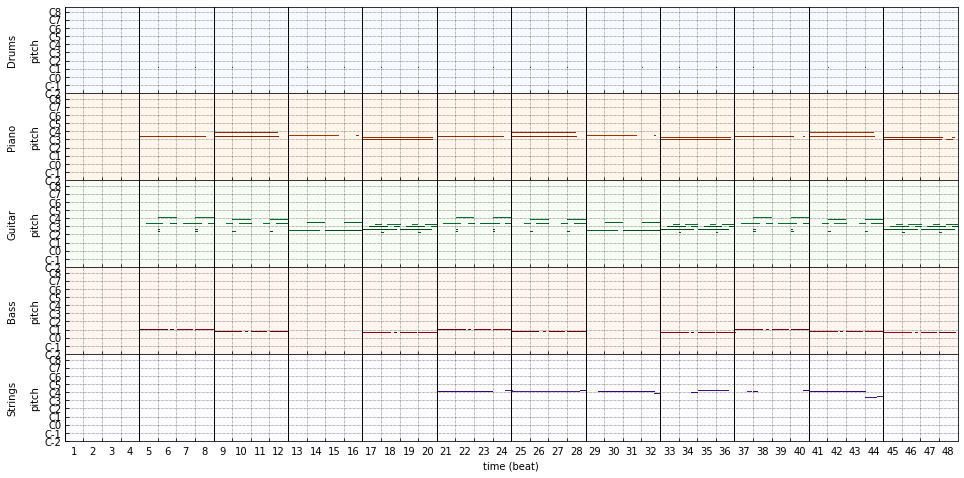

In [7]:
#visualize example
ex_song = 'TREVDFX128E07859E0'
song_dir = dataset_root / msd_id_to_dirs(ex_song) # 'TRQAOWZ128F93000A4', 'TREVDFX128E07859E0'
multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
multitrack.trim(end=48 * multitrack.resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(96, 12 * 96, 96):     
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [8]:
def save_midi(pianoroll):
    midif = pypianoroll.to_pretty_midi(pianoroll)
    # save to gdrive
    midif.write('/content/drive/My Drive/test.mid')
    return

In [ ]:
save_midi(multitrack)

NameError: ignored

# Preprocessing data for training

In [9]:
# tune data settings
n_tracks = 5  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
measure_resolution = 4 * beat_resolution
programs = [0, 0, 25, 33, 48]  # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
tempo = 100
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)


# Sampling
sample_interval = 100  # interval to run the sampler (in step)
n_samples = 4

In [10]:
data = []
# Iterate over all the songs in the ID list
for msd_id in tqdm(id_list):
    # Load the multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root / msd_id_to_dirs(msd_id)
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        data.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
print(f"Data shape : {data.shape}")

100%|██████████| 7323/7323 [05:34<00:00, 21.88it/s]


Successfully collect 26154 samples from 7323 songs
Data shape : (26154, 5, 64, 72)


In [11]:
with open('/content/drive/My Drive/data.npy', 'wb') as f:
  np.save(f, data)

In [ ]:
data = np.load('/content/drive/My Drive/data.npy', encoding='bytes')

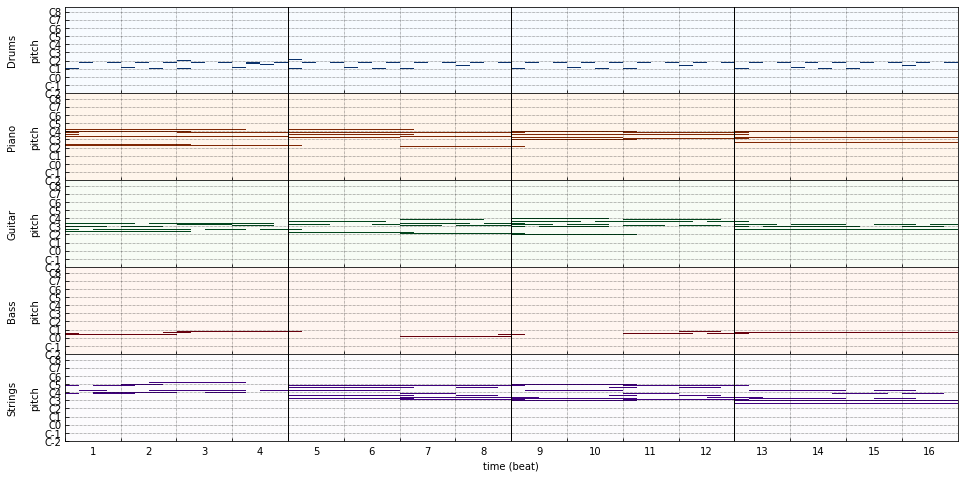

In [12]:
#Example of training sample: 4 measures with 4 beats in 1 measure, beat resolution = 4
#Thus training example has 64 timesteps with 72 pitches
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        data[1][idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

# Dataset and data loader

In [13]:
# Training
batch_size = 16
latent_dim = 128


In [14]:
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [15]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        data[1][idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)

# GAN model

Generator

In [16]:
class GeneraterBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

In [17]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneraterBlock(4736, 256, (4, 1, 1), (4, 1, 1))
        self.transconv1 = GeneraterBlock(256, 128, (1, 4, 1), (1, 4, 1))
        self.transconv2 = GeneraterBlock(128, 64, (1, 1, 4), (1, 1, 4))
        self.transconv3 = GeneraterBlock(64, 32, (1, 1, 3), (1, 1, 1))
        self.transconv4 = torch.nn.ModuleList([
            GeneraterBlock(32, 16, (1, 4, 1), (1, 4, 1))
            for _ in range(n_tracks)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneraterBlock(16, 1, (1, 1, 12), (1, 1, 12))
            for _ in range(n_tracks)
        ])

    def forward(self, x, y):
        new_y = y.reshape(16, 4608)
        x = torch.cat((x, new_y), 1)
        x = x.view(-1, 4736, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = [transconv(x) for transconv in self.transconv4]
        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        x[:, 1, :, :] = y
        return x

In [18]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [19]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [20]:
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks)
        ])
        self.conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1)) for _ in range(n_tracks)
        ])
        self.conv2 = DiscriminatorBlock(16 * 5, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (2, 1, 1), (1, 1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (3, 1, 1), (3, 1, 1))
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x):
        # x[:,1,:,:] = y
        x = x.view(-1, n_tracks, n_measures, measure_resolution, n_pitches)
        
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)          
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

In [21]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [22]:
def train_one_step(d_optimizer, g_optimizer, real_samples, piano):
    """Train the networks for one step."""

    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()
        piano = piano.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent, piano)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

In [23]:
# Create data loader
# data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

for real_samples in data_loader:
    sample_piano_part = real_samples[0][:16,1,:,:]
    break

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(16, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()
    sample_piano_part = sample_piano_part.cuda()


# Create an empty dictionary to sotre history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0

Number of parameters in G: 5032543
Number of parameters in D: 204321


In [28]:
!pip install torch-summary

In [31]:
from torchsummary import summary

summary(generator, (16, 5, 64, 72), torch.tensor((16, 64, 72)))

RuntimeError: ignored

In [ ]:
for real_samples in data_loader:
    sample_piano_part = real_samples[0][:4,1,:,:].reshape(4, 4608)
    break

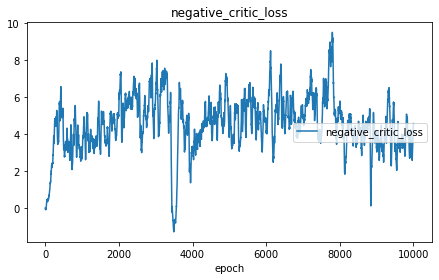

(d_loss=-6.125220, g_loss= 7.631812): 100%|█| 10000/10000 [59:35<00:00,  5.70it/

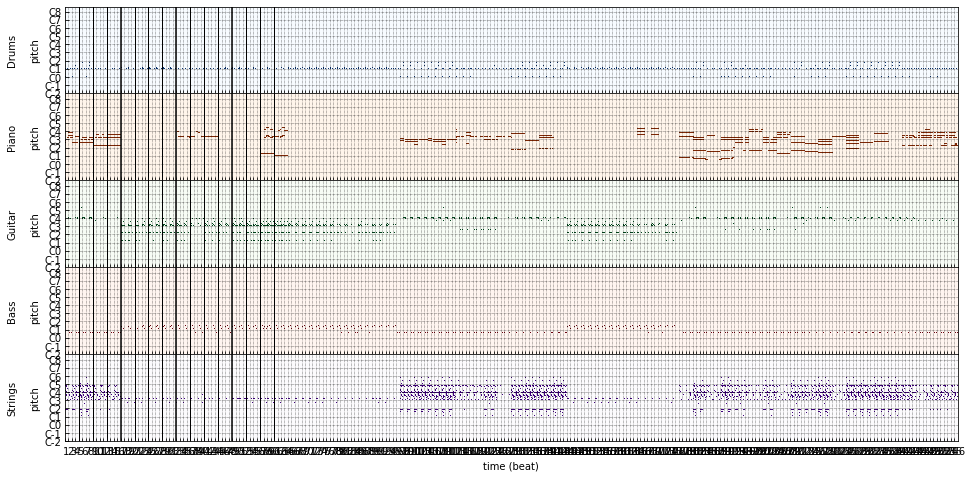

(d_loss=-6.125220, g_loss= 7.631812): 10001it [59:43,  1.23s/it]                

In [24]:
n_steps = 10000
losses = []
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)
ministep = 0
# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        piano_part = real_samples[0][:,1,:,:]
        # Train the neural networks
        ministep += 1
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples[0], piano_part)
        losses.append([d_loss, g_loss])
        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        liveloss.update({'negative_critic_loss': -running_d_loss})
        # liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
        
        # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent, sample_piano_part).cpu().detach().numpy()
            history_samples[step] = samples

            # Display loss curves
            clear_output(True)
            if step > 0:
                liveloss.send()
            
            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(
                zip(programs, is_drums, track_names)
            ):
                pianoroll = np.pad(
                    samples[idx] > 0.5,
                    ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
                )
                tracks.append(
                    Track(
                        name=track_name,
                        program=program,
                        is_drum=is_drum,
                        pianoroll=pianoroll
                    )
                )
            m = Multitrack(
                tracks=tracks,
                tempo=tempo_array,
                resolution=beat_resolution
            )
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(
                    measure_resolution,
                    4 * measure_resolution * n_measures,
                    measure_resolution
                ):
                    if x % (measure_resolution * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.show()
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

Step=0


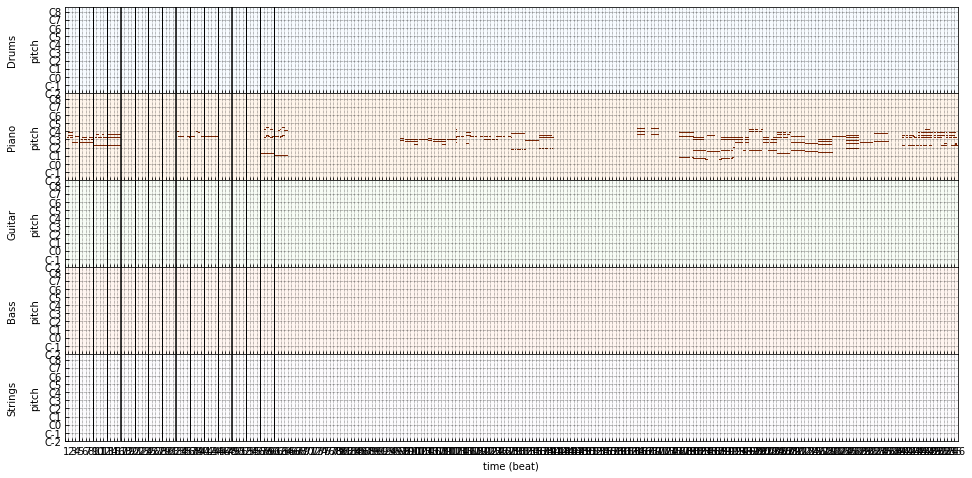

Step=100


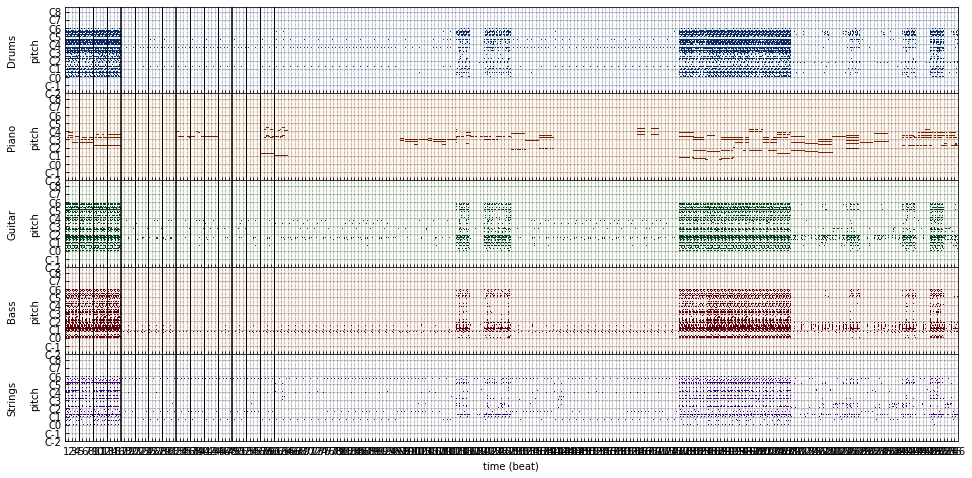

Step=1000


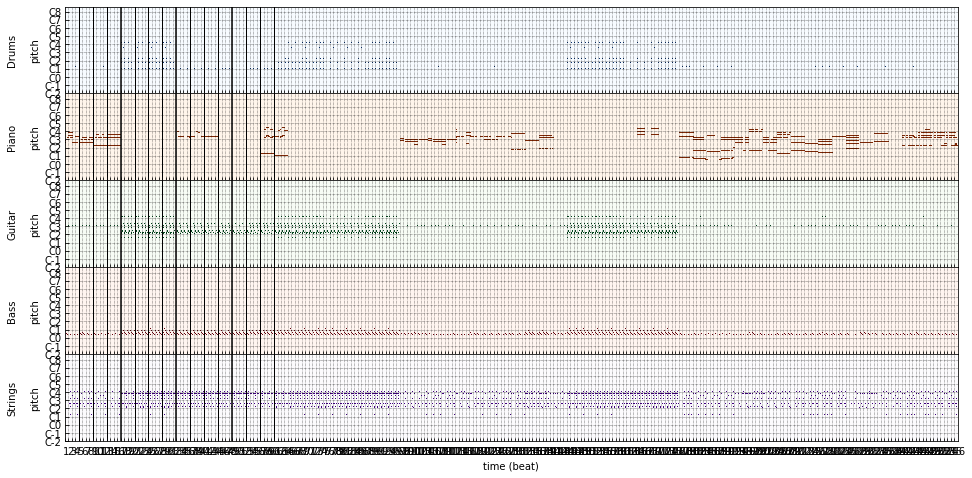

Step=10000


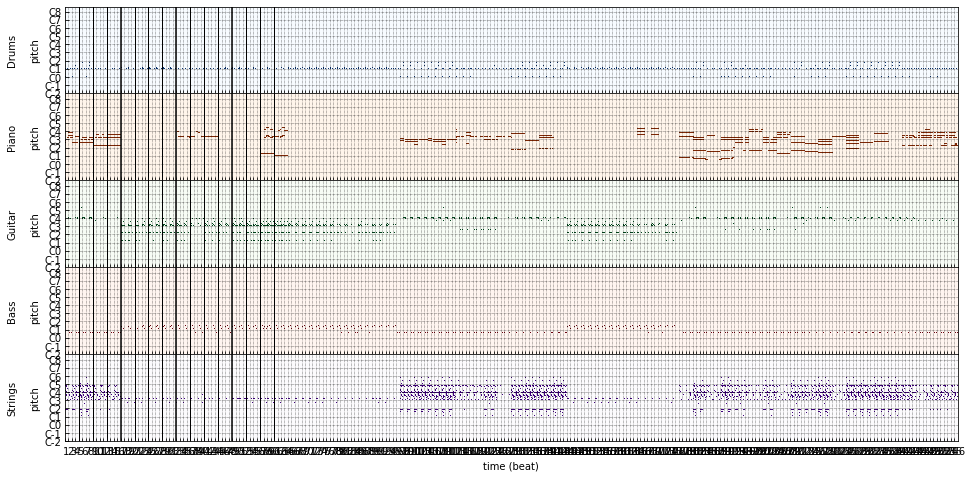

Step=10000


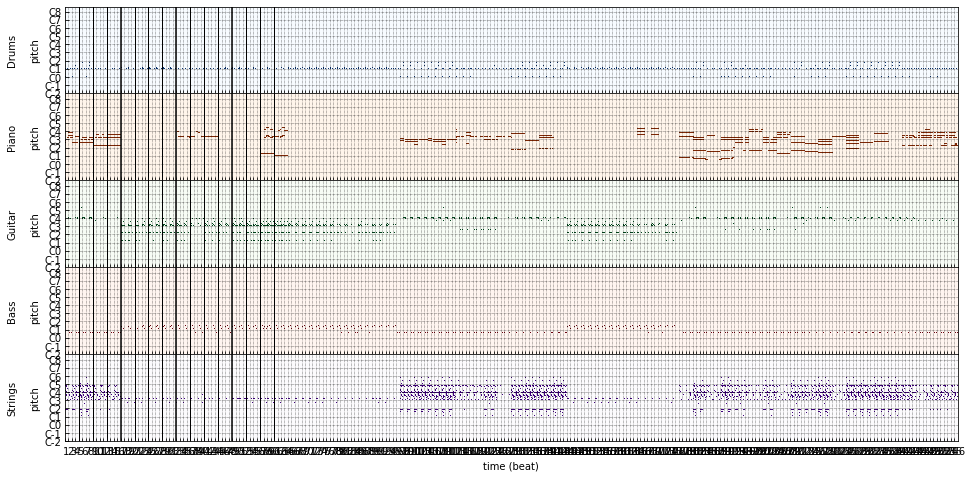

In [27]:
# Show history
steps = [0, sample_interval, 10 * sample_interval, 100 * sample_interval, n_steps]
for step in steps:
    print(f"Step={step}")
    samples = history_samples[step].transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
        )
        tracks.append(
            Track(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll,
            )
        )
    m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
    axs = m.plot()
    for ax in axs:
        for x in range(
            measure_resolution,
            4 * measure_resolution * n_measures,
            measure_resolution
        ):
            if x % (measure_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((16, 8))
    plt.show()

In [26]:
m = pypianoroll.load("/content/drive/My Drive/newresult.npz")
midi = pypianoroll.to_pretty_midi(m)
m.write("/content/drive/My Drive/newresult.mid")

In [25]:
pypianoroll.save("/content/drive/My Drive/newresult.npz", m)

In [ ]:
generator.eval()
samples = generator(sample_latent).cpu().detach().numpy()
history_samples[step] = samples

# Display generated samples
samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
tracks = []
for idx, (program, is_drum, track_name) in enumerate(
    zip(programs, is_drums, track_names)
):
    pianoroll = np.pad(
        samples[idx] > 0.5,
        ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
    )
    tracks.append(
        Track(
            name=track_name,
            program=program,
            is_drum=is_drum,
            pianoroll=pianoroll
        )
    )
m = Multitrack(
    tracks=tracks,
    tempo=tempo_array,
    resolution=beat_resolution
)
axs = m.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(
        measure_resolution,
        4 * measure_resolution * n_measures,
        measure_resolution
    ):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()


In [ ]:
mm = pypianoroll.from_pretty_midi(m)
mm.write('/content/drive/My Drive/n.mid')

In [ ]:
def save_midi(pianoroll):
    midif = pypianoroll.to_pretty_midi(pianoroll)
    # save to gdrive
    midif.write(f'/content/drive/My Drive/{pianoroll}.mid')
    return

In [32]:
def get_num_pitch_used(pianoroll):
    """Return the number of unique pitches used in a piano-roll."""
    return np.sum(np.sum(pianoroll, 0) > 0)
    
def get_qualified_note_rate(pianoroll, threshold=2):
    """Return the ratio of the number of the qualified notes (notes longer than
    `threshold` (in time step)) to the total number of notes in a piano-roll."""
    padded = np.pad(pianoroll.astype(int), ((1, 1), (0, 0)), 'constant')
    diff = np.diff(padded, axis=0)
    flattened = diff.T.reshape(-1,)
    onsets = (flattened > 0).nonzero()[0]
    offsets = (flattened < 0).nonzero()[0]
    num_qualified_note = (offsets - onsets >= threshold).sum()
    return num_qualified_note / len(onsets)

def get_polyphonic_ratio(pianoroll, threshold=2):
    """Return the ratio of the number of time steps where the number of pitches
    being played is larger than `threshold` to the total number of time steps"""
    return np.sum(np.sum(pianoroll, 1) >= threshold) / pianoroll.shape[0]

def get_in_scale(chroma, scale_mask=None):
    """Return the ratio of chroma."""
    measure_chroma = np.sum(chroma, axis=0)
    in_scale = np.sum(np.multiply(measure_chroma, scale_mask, dtype=float))
    return in_scale / np.sum(chroma)

def get_drum_pattern(measure, drum_filter):
    """Return the drum_pattern metric value."""
    padded = np.pad(measure, ((1, 0), (0, 0)), 'constant')
    measure = np.diff(padded, axis=0)
    measure[measure < 0] = 0

    max_score = 0
    for i in range(6):
        cdf = np.roll(drum_filter, i)
        score = np.sum(np.multiply(cdf, np.sum(measure, 1)))
        if score > max_score:
            max_score = score

    return  max_score / np.sum(measure)

def get_harmonicity(bar_chroma1, bar_chroma2, resolution, tonal_matrix=None):
    """Return the harmonicity metric value"""
    if tonal_matrix is None:
        tonal_matrix = get_tonal_matrix()
        warnings.warn("`tonal matrix` not specified. Use default tonal matrix",
                      RuntimeWarning)
    score_list = []
    for r in range(bar_chroma1.shape[0]//resolution):
        start = r * resolution
        end = (r + 1) * resolution
        beat_chroma1 = np.sum(bar_chroma1[start:end], 0)
        beat_chroma2 = np.sum(bar_chroma2[start:end], 0)
        score_list.append(tonal_dist(beat_chroma1, beat_chroma2, tonal_matrix))
    return np.mean(score_list)

def to_chroma(pianoroll):
    """Return the chroma features (not normalized)."""
    padded = np.pad(pianoroll, ((0, 0), (0, 12 - pianoroll.shape[1] % 12)),
                    'constant')
    return np.sum(np.reshape(padded, (pianoroll.shape[0], 12, -1)), 2)

def tonal_dist(chroma1, chroma2, tonal_matrix=None):
    """Return the tonal distance between two chroma features."""
    if tonal_matrix is None:
        tonal_matrix = get_tonal_matrix()
        warnings.warn("`tonal matrix` not specified. Use default tonal matrix",
                      RuntimeWarning)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        chroma1 = chroma1 / np.sum(chroma1)
        chroma2 = chroma2 / np.sum(chroma2)
    result1 = np.matmul(tonal_matrix, chroma1)
    result2 = np.matmul(tonal_matrix, chroma2)
    return np.linalg.norm(result1 - result2)

In [37]:
m=m.binarize()

In [40]:
get_num_pitch_used(m) / 64

138.875

In [ ]:
metric_map = config['metric_map']
tonal_distance_pairs = config['tonal_distance_pairs']
track_names = config['track_names']
beat_resolution = config['beat_resolution']
drum_filter = config['drum_filter']
        self.scale_mask = config['scale_mask']
        self.tonal_matrix = get_tonal_matrix(
            config['tonal_matrix_coefficient'][0],
            config['tonal_matrix_coefficient'][1],
            config['tonal_matrix_coefficient'][2]
        )

metric_names = [
'empty_bar',
'pitch_used',
'qualified_note',
'polyphonicity',
'in_scale',
'drum_pattern',
'chroma_used',
]

In [35]:
score_matrix = np.empty((len(metric_names), len(track_names),
                                 bars.shape[0]))
score_matrix.fill(np.nan)
score_pair_matrix = np.zeros((len(self.tonal_distance_pairs),
                              bars.shape[0]))
score_pair_matrix.fill(np.nan)

NameError: ignored